<a href="https://colab.research.google.com/github/meryamhzamiensi/Quantum-Enhanced-Deep-Learning-for-Precision-Drug-Design-in-Breast-Cancer-Treatment/blob/ML-models/Copie_de_PCD_classic_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 18.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import psutil
import tracemalloc
import time
import os
import pickle
import pennylane as qml

In [ ]:

def track_memory_usage():
    """
    Track memory usage of the current process

    Returns:
    dict: Memory usage statistics
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()

    return {
        'rss_mb': memory_info.rss / (1024 * 1024),  # Resident Set Size in MB
        'vms_mb': memory_info.vms / (1024 * 1024),  # Virtual Memory Size in MB
    }


In [ ]:
# Helper function to check device
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], output_dim=5, dropout_rate=0.3):
        super(ImprovedMLP, self).__init__()

        # Input layer -> First hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second hidden layer
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.dropout2 = nn.Dropout(dropout_rate)

        # Third hidden layer
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.dropout3 = nn.Dropout(dropout_rate)

        # Output layer
        self.output = nn.Linear(hidden_dims[2], output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Apply appropriate weight initialization to all layers"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # First hidden layer
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Second hidden layer
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Third hidden layer
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Output layer
        x = self.output(x)
        return x

# Training function with early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer,
                num_epochs=100, patience=10, verbose=True):
    """
    Train the model with early stopping
    """
    device = get_device()
    model = model.to(device)

    # Initialize tracking variables
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    best_test_loss = float('inf')
    best_model_state = None
    no_improve_count = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # Calculate epoch statistics
        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        # Calculate epoch test statistics
        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_acc = correct / total
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)

        # Learning rate adjustment - manual step instead of scheduler
        if epoch > 0 and epoch % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * 0.9

        # Early stopping check
        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            best_model_state = model.state_dict().copy()
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            if verbose:
                print(f'Early stopping at epoch {epoch+1}')
            break

        # Print progress
        if verbose and (epoch % 5 == 4 or epoch == num_epochs - 1):
            print(f'Epoch {epoch+1}/{num_epochs} | '
                  f'Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | '
                  f'Test Loss: {epoch_test_loss:.4f}, Acc: {epoch_test_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_state)

    return model, {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs
    }

In [ ]:
# Function to evaluate model performance
def evaluate_model(model, test_loader, criterion, class_names):
    """
    Evaluate model performance on test set
    """
    device = get_device()
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate overall metrics
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_targets, all_predictions)

    # Generate detailed classification report
    report = classification_report(all_targets, all_predictions,
                                  target_names=class_names,
                                  output_dict=True)

    # Generate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)

    results = {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm
    }

    # Print summary results
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions, target_names=class_names))

    return results

# Function to plot training history
def plot_training_history(history):
    """
    Plot training and validation metrics
    """
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='Training Loss')
    plt.plot(history['test_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_accs'], label='Training Accuracy')
    plt.plot(history['test_accs'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    """
    Plot confusion matrix as a heatmap
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


In [ ]:
# Set up quantum device (using 4 qubits)
n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)

# Define quantum circuit for feature embedding
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    """
    Quantum circuit that processes inputs using data re-uploading technique
    to handle high-dimensional data with limited qubits
    """
    # For high-dimensional data, we'll use a data re-uploading strategy
    # This allows us to process all features through multiple circuit layers

    # Calculate number of complete "feature blocks" we need to process all inputs
    # Each qubit can handle one feature at a time, but we reuse qubits for multiple features
    features_per_layer = n_qubits

    # Normalize all inputs to range [0, π]
    normalized_inputs = np.clip(inputs, -1, 1) * np.pi

    # Process each feature block (data re-uploading technique)
    for start_idx in range(0, len(normalized_inputs), features_per_layer):
        # Get the next block of features (up to features_per_layer)
        end_idx = min(start_idx + features_per_layer, len(normalized_inputs))
        feature_block = normalized_inputs[start_idx:end_idx]

        # Pad the block if needed to match qubit count
        if len(feature_block) < features_per_layer:
            feature_block = np.pad(feature_block, (0, features_per_layer - len(feature_block)))

        # Encode this block of features into quantum states
        for i in range(features_per_layer):
            qml.RY(feature_block[i], wires=i)

        # Apply entangling operations between adjacent qubits
        for i in range(n_qubits-1):
            qml.CNOT(wires=[i, i+1])

    # Final parameterized rotation gates controlled by weights
    for i in range(n_qubits):
        qml.RX(weights[i], wires=i)

    # Measure all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Initialize quantum weights - with proper seed for reproducibility
np.random.seed(42)
quantum_weights = np.random.randn(n_qubits)

def quantum_transform(X_data):
    """
    Transform data using quantum circuit - processing all features
    via data re-uploading technique

    Args:
        X_data: Input features (all features will be used)
    """
    # Ensure 2D array input
    if len(X_data.shape) == 1:
        X_data = X_data.reshape(1, -1)

    print(f"Processing all {X_data.shape[1]} features through {n_qubits} qubits using data re-uploading")

    # Track processing time for large datasets
    import time
    start_time = time.time()

    quantum_features = []
    total_samples = X_data.shape[0]

    # Process each sample
    for idx, sample in enumerate(X_data):
        # Show progress for large datasets
        if idx % max(1, total_samples // 10) == 0:
            elapsed = time.time() - start_time
            print(f"Processing sample {idx}/{total_samples} ({idx/total_samples*100:.1f}%) - Elapsed: {elapsed:.2f}s")

        # Convert sample to numpy array and flatten
        sample = np.array(sample, dtype=np.float32).flatten()

        # Get quantum features for this sample using all original features
        quantum_features.append(quantum_circuit(sample, quantum_weights))

    print(f"Quantum transformation completed in {time.time() - start_time:.2f} seconds")

    # Convert to numpy array - shape will be (n_samples, n_qubits)
    return np.array(quantum_features)

In [ ]:
# Main execution function
def run_breast_cancer_classification():
    """
    Complete pipeline for breast cancer classification
    """
    print("Loading and preparing breast cancer dataset...")

    # 1. Load data - adjust path as needed
    breast_cancer_data = pd.read_csv('processed_dataset.csv')

    # 2. Create target classes
    # Convert continuous IC50 values to categorical classes
    y = pd.cut(
        breast_cancer_data['LN_IC50'],
        bins=5,
        labels=['very_low', 'low', 'medium', 'high', 'excellent']
    )
    print("\nTarget class distribution:")
    print(y.value_counts())

    # Encode target labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    class_names = label_encoder.classes_

    # 3. Prepare features
    X = breast_cancer_data.drop(columns=['LN_IC50'])

    # 4. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded  # Maintain class distribution
    )

    print(f"\nFinal dataset shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

    # 5. Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 6. Create a hybrid model approach
    try:
        print("\nApplying quantum transformation...")

        # Process all features through quantum circuit
        X_train_q = quantum_transform(X_train_scaled)
        X_test_q = quantum_transform(X_test_scaled)
        print(f"Quantum features shape: {X_train_q.shape}")

        # For hybrid approach: concatenate quantum features with original features
        # This preserves all original information while adding quantum-processed features
        X_train_hybrid = np.hstack((X_train_scaled, X_train_q))
        X_test_hybrid = np.hstack((X_test_scaled, X_test_q))

        print(f"Hybrid features shape: {X_train_hybrid.shape}")

        # Use hybrid features (original + quantum) for our model
        X_train_scaled = X_train_hybrid
        X_test_scaled = X_test_hybrid
        input_dim = X_train_scaled.shape[1]
        print("Quantum-classical hybrid transformation successful!")

        # Store a flag for logging
        using_quantum = True
    except Exception as e:
        print(f"Error during quantum transformation: {e}")
        print("Proceeding with original classical features only...")
        input_dim = X_train_scaled.shape[1]
        using_quantum = False

    # 7. Convert to PyTorch tensors
    device = get_device()
    print(f"\nUsing device: {device}")

    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)

    # 8. Create DataLoaders for batch processing
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # 9. Initialize model with correct input dimension
    model = ImprovedMLP(
        input_dim=input_dim,
        hidden_dims=[128, 64, 32],  # Three hidden layers
        output_dim=5,  # 5 classes
        dropout_rate=0.3
    )

    # Print model architecture
    print("\nModel Architecture:")
    print(model)

    # 10. Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # 11. Train model
    print("\nTraining model...")
    tracemalloc.start()
    # Initial memory snapshot
    initial_memory = track_memory_usage()
    print("Initial Memory Usage:")
    print(f"RSS: {initial_memory['rss_mb']:.2f} MB")
    print(f"VMS: {initial_memory['vms_mb']:.2f} MB")

    start_time = time.time()

    trained_model, history = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=100,
        patience=15
    )
    end_time = time.time()  # Arrête le chrono
    execution_time = end_time - start_time  # Calcul du temps

    print(f"Temps d'exécution : {execution_time:.6f} secondes")
    # Get memory allocation details
    current, peak = tracemalloc.get_traced_memory()
    print(f"\nCurrent memory usage: {current / 10**6:.2f} MB")
    print(f"Peak memory usage: {peak / 10**6:.2f} MB")
    tracemalloc.stop()

    # 12. Plot training history
    plot_training_history(history)

    # 13. Evaluate model
    print("\nEvaluating model...")
    evaluation = evaluate_model(
        model=trained_model,
        test_loader=test_loader,
        criterion=criterion,
        class_names=class_names
    )

    # 14. Plot confusion matrix
    plot_confusion_matrix(evaluation['confusion_matrix'], class_names)

    #15. Save model if needed
    torch.save(trained_model.state_dict(), 'breast_cancer_model.pth')

    return trained_model, evaluation, history

Starting Quantum-Enhanced Neural Network for Breast Cancer Classification
Loading and preparing breast cancer dataset...

Target class distribution:
LN_IC50
medium       6726
high         4457
low          1428
very_low      340
excellent     155
Name: count, dtype: int64

Final dataset shapes:
X_train: (10484, 503), y_train: (10484,)
X_test: (2622, 503), y_test: (2622,)

Applying quantum transformation...
Processing all 503 features through 4 qubits using data re-uploading
Processing sample 0/10484 (0.0%) - Elapsed: 0.00s
Processing sample 1048/10484 (10.0%) - Elapsed: 189.40s
Processing sample 2096/10484 (20.0%) - Elapsed: 379.34s
Processing sample 3144/10484 (30.0%) - Elapsed: 564.15s
Processing sample 4192/10484 (40.0%) - Elapsed: 748.22s
Processing sample 5240/10484 (50.0%) - Elapsed: 933.24s
Processing sample 6288/10484 (60.0%) - Elapsed: 1118.18s
Processing sample 7336/10484 (70.0%) - Elapsed: 1302.79s
Processing sample 8384/10484 (80.0%) - Elapsed: 1487.01s
Processing sample 94

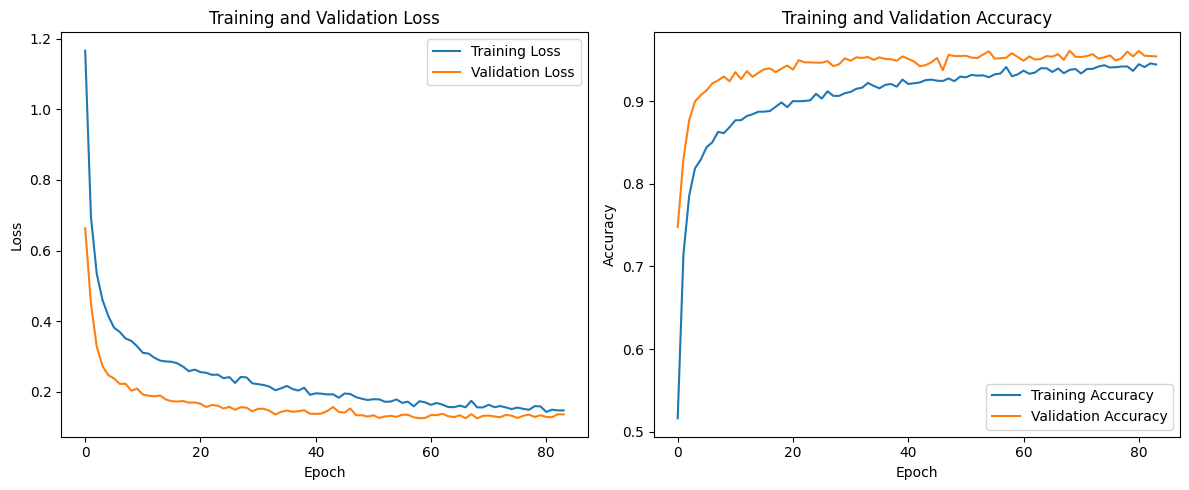


Evaluating model...
Test Loss: 0.1358
Test Accuracy: 0.9542

Classification Report:
              precision    recall  f1-score   support

   excellent       0.94      0.94      0.94        31
        high       0.94      0.98      0.96       892
         low       0.93      0.91      0.92       286
      medium       0.97      0.95      0.96      1345
    very_low       0.89      0.96      0.92        68

    accuracy                           0.95      2622
   macro avg       0.93      0.95      0.94      2622
weighted avg       0.95      0.95      0.95      2622



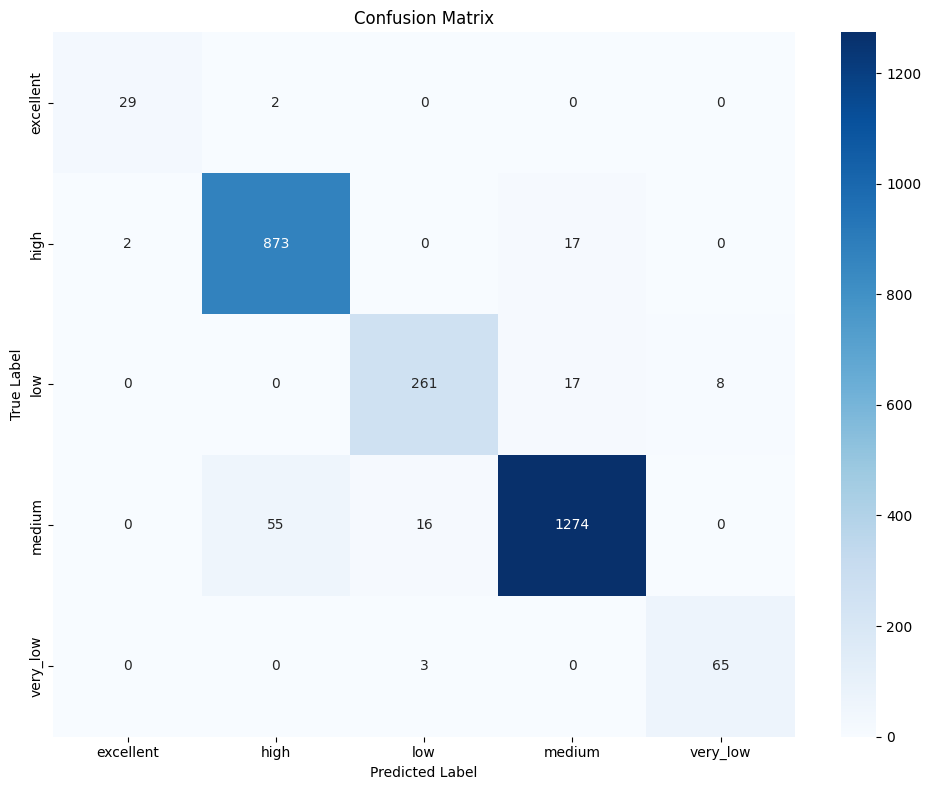

Pipeline completed successfully!


In [ ]:
# Execute the pipeline
if __name__ == "__main__":
    print("Starting Quantum-Enhanced Neural Network for Breast Cancer Classification")
    trained_model, evaluation, history = run_breast_cancer_classification()
    print("Pipeline completed successfully!")

In [ ]:
def save_as_pickle(model, filepath='model.pkl'):
    """Save entire model as .pkl file"""
    try:
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved as {filepath}")
    except Exception as e:
        print(f"Error saving model: {e}")
        raise

save_as_pickle(trained_model, 'breast_cancer_MLP_model.pkl')